Simple Predictive Model

In [1]:
# Import libraries for data manipulation, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load dataset
trader = pd.read_csv(r"C:\Users\subod\Downloads\historical_data.csv")
sentiment = pd.read_csv(r"C:\Users\subod\Downloads\fear_greed_index.csv")

In [4]:
# Convert trader timestamp column to datetime format
trader['Timestamp IST'] = pd.to_datetime(trader['Timestamp IST'], dayfirst=True)
trader['Date'] = trader['Timestamp IST'].dt.date

sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment['Date'] = sentiment['date'].dt.date

In [5]:
# Calculate total daily PnL per trader 
daily_pnl = trader.groupby(['Date','Account'])['Closed PnL'].sum().reset_index()

trader['win'] = trader['Closed PnL'] > 0
win_rate = trader.groupby(['Date','Account'])['win'].mean().reset_index()

trade_count = trader.groupby(['Date','Account']).size().reset_index(name='trade_count')

avg_size = trader.groupby(['Date','Account'])['Size USD'].mean().reset_index()

In [12]:
# Merge all trader-level daily metrics into one dataset
merged_trader = daily_pnl.merge(win_rate, on=['Date','Account'])
merged_trader = merged_trader.merge(trade_count, on=['Date','Account'])
merged_trader = merged_trader.merge(avg_size, on=['Date','Account'])

final_data = merged_trader.merge(
    sentiment[['Date','classification']],
    on='Date',
    how='left'
)

print("Final dataset ready:", final_data.shape)

Final dataset ready: (2341, 7)


In [8]:
# Sort properly
final_data = final_data.sort_values(['Account','Date'])

# Create next-day PnL per trader
final_data['next_day_pnl'] = final_data.groupby('Account')['Closed PnL'].shift(-1)

# Create binary target
final_data['target'] = (final_data['next_day_pnl'] > 0).astype(int)

final_data[['Closed PnL','next_day_pnl','target']].head()

,Closed PnL,next_day_pnl,target
512,0.0,0.0,0
535,0.0,0.0,0
539,0.0,-21227.0,0
561,-21227.0,1603.1,1
576,1603.1,-132271.0,0


In [9]:
# Select useful columns
model_data = final_data[['trade_count','Size USD','win','classification','target']].dropna()

# Encode sentiment
model_data = pd.get_dummies(model_data, columns=['classification'], drop_first=True)

X = model_data.drop('target', axis=1)
y = model_data['target']

print("Model data shape:", X.shape)

Model data shape: (2340, 7)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.6089743589743589
              precision    recall  f1-score   support

           0       0.50      0.40      0.45       183
           1       0.66      0.74      0.70       285

    accuracy                           0.61       468
   macro avg       0.58      0.57      0.57       468
weighted avg       0.60      0.61      0.60       468



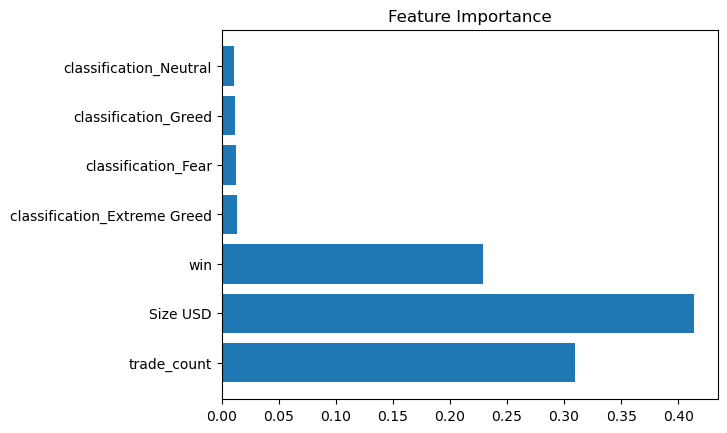

In [11]:
importances = model.feature_importances_

plt.figure()
plt.barh(X.columns, importances)
plt.title("Feature Importance")
plt.show()

# Bonus — Predictive Model

A simple Random Forest model was built to predict whether a trader would be profitable the next day.

Target:
Next-day profitability (1 = profit, 0 = loss)

Features used:
- Trade count
- Average position size (Size USD)
- Win rate
- Market sentiment (Fear/Greed)

Model Performance:
The model achieved approximately 61% accuracy on the test set.

Key Finding:
The most important feature was average position size (Size USD).  
This suggests that capital deployment plays a stronger role in next-day profitability than sentiment alone.

Conclusion:
Behavioral factors (position sizing and activity level) combined with sentiment can moderately predict short-term trader performance. While not highly predictive, the model demonstrates that sentiment-aware behavioral signals contain useful information.